##### 逻辑回归（分类）
- 解释性强，速度快

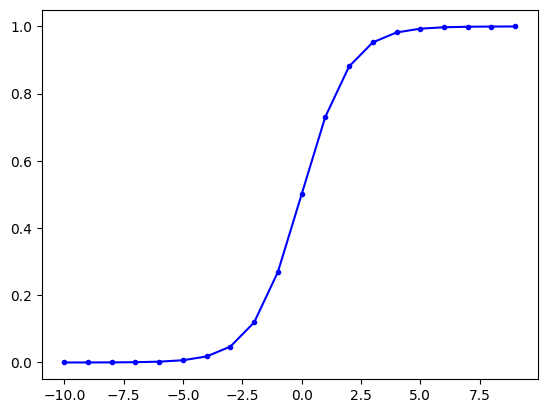

In [1]:
# Sigmoid函数
import numpy as np
import matplotlib.pyplot as plt
def sigmoid(x):
    return 1/(1 + np.exp(-x))
x,y = [],[]
for i in range(-10,10):
    x.append(i)
    y.append(sigmoid(i))
plt.plot(x,y,'b.-')
plt.show()

逻辑回归的模型假设：

$$
h_\theta(x) = \sigma(\theta^T x) = \frac{1}{1 + e^{-\theta^T x}}
$$

损失函数（对数似然函数）：

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y_i \log(h_\theta(x_i)) + (1 - y_i) \log(1 - h_\theta(x_i)) \right]
$$

梯度计算：

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta(x_i) - y_i \right) x_{ij}
$$

梯度下降更新规则：

$$
\theta_j := \theta_j - \alpha \cdot \frac{\partial J(\theta)}{\partial \theta_j}
$$


In [2]:
# 多分类任务 先找其中一种 为1，其他都 为0
# 拆解为多个二分类
from scipy.optimize import minimize
""""
minimize(fun, x0, args=(), method=None, jac=None, hess=None,
             hessp=None, bounds=None, constraints=(), tol=None,
             callback=None, options=None)
fun: 优化函数
x0: 求解参数
method: 梯度下降方法
jac: 梯度下降迭代公式
callback: 记录参数
"""
from utils.features.prepare_for_training import prepare_for_training
class LogisticRegression:
    def __init__(self, data, labels, polynomial_degree=0, sinusoid_degree=0, normalize_data=False):
        """
        1.对数据进行预处理操作
        2.先得到所有的特征个数
        3.初始化参数矩阵
        """
        (data_processed,
         features_mean,
         features_deviation) = prepare_for_training(data, polynomial_degree, sinusoid_degree, normalize_data=False)
 
        self.data = data_processed
        self.labels = labels
        self.unique_labels = np.unique(labels)  # 去重
        self.features_mean = features_mean
        self.features_deviation = features_deviation
        self.polynomial_degree = polynomial_degree
        self.sinusoid_degree = sinusoid_degree
        self.normalize_data = normalize_data

        # 特征个数
        num_features = self.data.shape[1]
        # 标签个数
        num_unique_labels = np.unique(labels).shape[0]
        self.theta = np.zeros((num_unique_labels, num_features))
 
    def train(self, max_iterations=1000):
        cost_histories = []
        num_features = self.data.shape[1] 
        for label_index, unique_label in enumerate(self.unique_labels): #把每个标签都训练
            current_initial_theta = np.copy(self.theta[label_index].reshape(num_features, 1)) #当前标签的参数
            current_lables = (self.labels == unique_label).astype(float) #当前特征的对应的标签
            (current_theta, cost_history) = LogisticRegression.gradient_descent(self.data, current_lables,
                                                                                current_initial_theta, max_iterations) #执行梯度下降
            self.theta[label_index] = current_theta.T #更新
            cost_histories.append(cost_history)
 
        return self.theta, cost_histories
    """
    @staticmethod：
    1.不依赖于实例或类的数据： 静态方法不需要访问类的实例或类本身，它通常用于那些与类的状态无关的操作。
    2.可以通过类名直接调用： 静态方法可以通过类名直接调用，而不需要先创建类的实例。也可以通过实例调用，但通常更推荐通过类调用。
    3.避免不必要的实例化： 如果某个方法不依赖实例的状态，就没有必要将它定义为实例方法（即普通方法），这时可以使用静态方法。
    """
    @staticmethod
    def gradient_descent(data, labels, current_initial_theta, max_iterations):
        cost_history = []
        num_features = data.shape[1]        # flatten():将多维数组转换为一维数组：flatten() 方法将一个多维数组“压平”成一个一维数组。
        
        result = minimize(
            # 要优化的目标： 优化函数 损失函数
            lambda current_theta: LogisticRegression.cost_function(data, labels,
                                                                   current_theta.reshape(num_features, 1)), 
            # 初始化的权重参数
            current_initial_theta.flatten(),
            # 选择优化策略
            method='CG',#共轭梯度

            # 梯度下降迭代计算公式
            jac=lambda current_theta: LogisticRegression.gradient_step(data, labels,
                                                                       current_theta.reshape(num_features, 1)),
            # 记录结果
            callback=lambda current_theta: cost_history.append(
                LogisticRegression.cost_function(data, labels, current_theta.reshape((num_features, 1)))),
            # 迭代次数
            options={'maxiter': max_iterations}
        )
        optimized_theta = result.x.reshape(num_features, 1)
        return optimized_theta, cost_history
 
    #计算损失
    @staticmethod
    def cost_function(data, labels, theat): 
        num_examples = data.shape[0]
        predictions = LogisticRegression.hypothesis(data, theat)
        # y1 * log( h(x1) )
        cost1 = np.dot(labels[labels == 1].T, np.log(predictions[labels == 1])) 
        # (1-y0) * log( 1- h(x0) )
        cost0 = np.dot(1 - labels[labels == 0].T, np.log(1 - predictions[labels == 0]))
        cost = (-1 / num_examples) * (cost1 + cost0)
        return cost
 
    @staticmethod
    def hypothesis(data, theat):
        return sigmoid(np.dot(data, theat))
 
    @staticmethod #计算梯度值
    def gradient_step(data, labels, theta):
        num_examples = labels.shape[0]
        predictions = LogisticRegression.hypothesis(data, theta)
        label_diff = predictions - labels
        gradients = (1 / num_examples) * np.dot(data.T, label_diff)
 
        return gradients.T.flatten()
 
    def predict(self, data):
        num_examples = data.shape[0]
        data_processed = prepare_for_training(data, self.polynomial_degree, self.sinusoid_degree, self.normalize_data)[0]
        prob = LogisticRegression.hypothesis(data_processed, self.theta.T)
        max_prob_index = np.argmax(prob, axis=1) #把概率最大的那个值拿出来
        class_prediction = np.empty(max_prob_index.shape, dtype=object)
        for index, label in enumerate(self.unique_labels):
            class_prediction[max_prob_index == index] = label
        return class_prediction.reshape((num_examples, 1))


<function matplotlib.pyplot.show(close=None, block=None)>

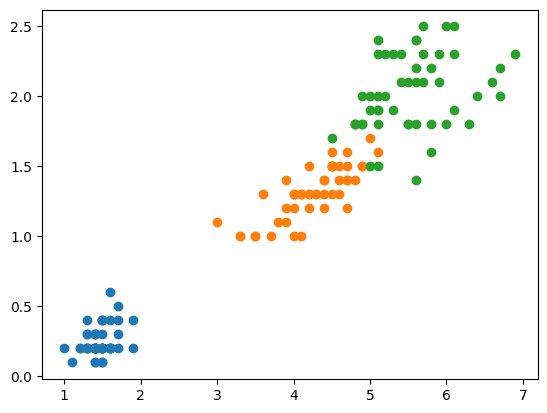

In [3]:
# 数据集导入
import pandas as pd
data = pd.read_csv('iris.csv')
iris_types = ['setosa','versicolor','virginica']

x_axis = 'Petal.Length'
y_axis = 'Petal.Width'
for iris_type in iris_types:
    plt.scatter(data[x_axis][data['Species'] == iris_type],
                data[y_axis][data['Species'] == iris_type],
                label = iris_type
                )
plt.show

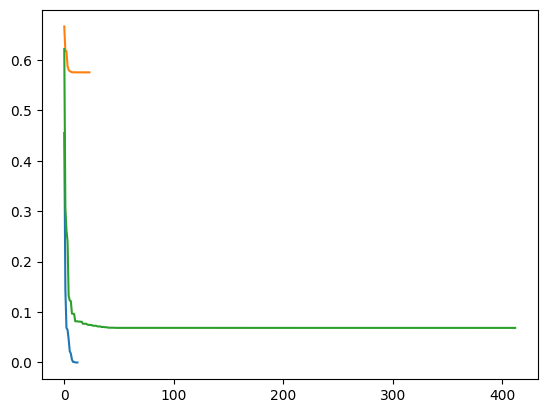

In [4]:
num_examples = data.shape[0]
x_train = data[[x_axis,y_axis]].values.reshape(num_examples,2) 
y_train = data['Species'].values.reshape(num_examples,1)

max_iter = 1000
polynomial_degree = 0 
sinusoid_degree = 0 
lr = LogisticRegression(x_train, y_train , polynomial_degree  ,sinusoid_degree)
theta , cost_histories =  lr.train(max_iter)
labels = lr.unique_labels
plt.plot(range(len(cost_histories[0])),cost_histories[0],label = labels[0])
plt.plot(range(len(cost_histories[1])),cost_histories[1],label = labels[1])
plt.plot(range(len(cost_histories[2])),cost_histories[2],label = labels[2])
plt.show()



In [5]:
y_trian_pred = lr.predict(x_train)
precision = np.sum(y_trian_pred == y_train) / y_train.shape[0] * 100
print(f'precision = {precision} %')

precision = 96.0 %


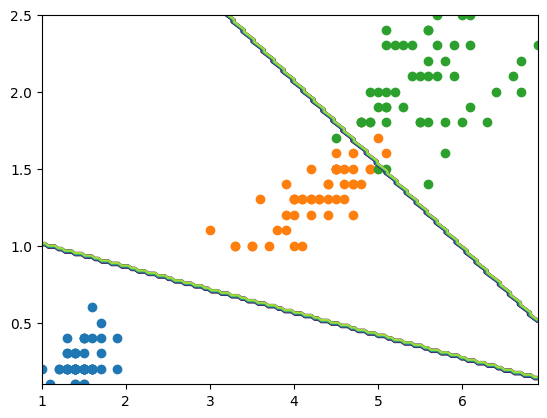

In [6]:
# 找到 x_trian 数组中第 0 列的最小值，并将其赋值给 x_min
x_min = np.min(x_train[:,0])
x_max = np.max(x_train[:,0])
# 找到 x_trian 数组中第 1 列的最小值，并将其赋值给 y_min
y_min = np.min(x_train[:,1])
y_max = np.max(x_train[:,1])
samples = 150

# np.linspace(x_min, x_max, samples) 生成一个一维数组，这个数组的值从 x_min 开始，到 x_max 结束，总共包含 samples 个等间距的值
X = np.linspace(x_min,x_max,samples)
Y = np.linspace(y_min,y_max,samples)

Z_1 = np.zeros((samples,samples))
Z_2 = np.zeros((samples,samples))
Z_3 = np.zeros((samples,samples))
# enumerate(X) 迭代时同时获取元素的索引和值
for x_index, x in enumerate(X):
    for y_index, y in enumerate(Y):
        # 整个数据分布全部覆盖
        data = np.array([[x,y]])
        prediction = lr.predict(data)
        if prediction == iris_types[0]:
            Z_1[x_index][y_index] = 1
        elif prediction == iris_types[1]:
            Z_2[x_index][y_index] = 1
        elif prediction == iris_types[2]:
            Z_3[x_index][y_index] = 1

for iris_type in iris_types:
    # 散点图
    plt.scatter(
        x_train[(y_train == iris_type).flatten() , 0],
        x_train[(y_train == iris_type).flatten() , 1],
        label = iris_type
        )
# 绘制等高线图
plt.contour(X,Y,Z_1)
plt.contour(X,Y,Z_2)
plt.contour(X,Y,Z_3)
plt.show()